In [1]:
import pandas as pd

cm_features = pd.read_csv('data/cm_features_with_name.csv')
cm_features

,month_id,country_id,gleditsch_ward,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,...,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,country,date
0,121,1,110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.952694,1.380676,3.333333,315260.986388,354505.092577,0.093750,1.034032,0.093750,Guyana,1990-01-01
1,121,2,115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,57.289771,3.922495,2.950609,264606.831667,264606.831667,0.062500,0.062500,0.062500,Suriname,1990-01-01
2,121,3,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35.755839,36.015231,17.956469,3244.939711,3244.939711,0.000000,0.000000,0.000000,Trinidad and Tobago,1990-01-01
3,121,4,101,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,28.946372,26.864392,2.249173,45295.968642,74555.476336,1.062500,1.062500,0.093750,Venezuela,1990-01-01
4,121,5,990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Samoa,1990-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71637,502,242,510,0.0,0.0,1.0,0.0,0.0,2.0,30.0,...,41.083011,6.915093,12.963241,1536.763246,1761.240449,4.412313,3.889290,2.105145,Tanzania,2021-10-01
71638,502,243,600,0.0,0.0,0.0,2.0,2.0,0.0,5.0,...,54.588834,8.417189,50.751212,815.035895,815.035895,0.823197,0.049630,0.060734,Morocco,2021-10-01
71639,502,244,435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.697300,3.774539,13.246217,93.401859,2661.952986,1.844790,1.055986,1.065787,Mauritania,2021-10-01
71640,502,245,625,3.0,3.0,9.0,2.0,1.0,42.0,82.0,...,53.047036,2.620623,118.656388,98.007034,926.166474,5.816131,4.897757,4.263890,Sudan,2021-10-01


In [2]:
from utilities import views_month_id_to_date

# load benchmark model
prediction_year = 2019
model_names = {
    "bootstrap": "bm_cm_bootstrap_expanded_",
    "poisson": "bm_cm_last_historical_poisson_expanded_",
}
benchmark_model = pd.read_parquet(f'Benchmarks/{model_names["bootstrap"]}{prediction_year}.parquet')
# there is 20 draws per each country per each month. Get the mean of the draws
benchmark_model = benchmark_model.groupby(['month_id', 'country_id']).mean().reset_index()
# add date column
benchmark_model['date'] = views_month_id_to_date(benchmark_model['month_id'])
benchmark_model

,month_id,country_id,outcome,date
0,469,1,30.687,2019-01-01
1,469,2,15.771,2019-01-01
2,469,3,17.758,2019-01-01
3,469,4,17.323,2019-01-01
4,469,5,14.683,2019-01-01
...,...,...,...,...
2287,480,242,18.344,2019-12-01
2288,480,243,19.228,2019-12-01
2289,480,244,24.573,2019-12-01
2290,480,245,31.771,2019-12-01


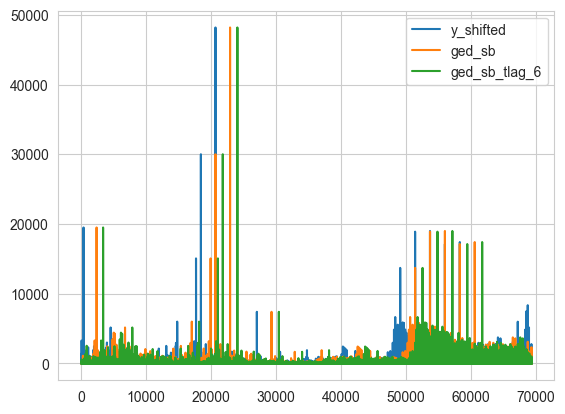

In [3]:
cm_features['y_shifted'] = cm_features.groupby('country_id')['ged_sb'].shift(-12)
# show na for y_shifted
cm_features[cm_features['y_shifted'].isna()]
# drop na
cm_features = cm_features.dropna()
# plot y_shifted per month
from matplotlib import pyplot as plt

cm_features['y_shifted'].plot()
cm_features['ged_sb'].plot()
cm_features['ged_sb_tlag_6'].plot()
plt.legend()
plt.show()

In [4]:
# drop all ged_sb_tlag_x except for the ged_sb_tlag_6
cm_features = cm_features.drop(columns=['country', 'gleditsch_ward'])
# cm_features = cm_features.drop(
#     columns=['ged_sb_tlag_2', 'ged_sb_tlag_3', 'ged_sb_tlag_4', 'ged_sb_tlag_5', 'ged_sb_tlag_1', 'ged_sb_tlag_6', ])
# # drop ged_sb, ged_ns, ged_os, acled_sb, acled_sb_ count, acled_os, ged_sb_tsum_24
# cm_features = cm_features.drop(
#     columns=['ged_sb', 'ged_ns', 'ged_os', 'acled_sb', 'acled_sb_count', 'acled_os', 'ged_sb_tsum_24', 'ged_os_tlag_1'])
# # drop splag_1_decay_ged_sb_5, splag_1_decay_ged_os_5, splag_1_decay_ged_ns_5, decay_ged_sb_5, decay_ged_os_5, decay_ged_sb_500, decay_ged_os_100, decay_ged_ns_5, decay_ged_ns_100, decay_acled_sb_5, decay_acled_os_5, decay_acled_ns_5
# cm_features = cm_features.drop(
#     columns=['splag_1_decay_ged_sb_5', 'splag_1_decay_ged_os_5', 'splag_1_decay_ged_ns_5', 'decay_ged_sb_5',
#              'decay_ged_os_5', 'decay_ged_sb_500', 'decay_ged_os_100', 'decay_ged_ns_5', 'decay_ged_ns_100',
#              'decay_acled_sb_5', 'decay_acled_os_5', 'decay_acled_ns_5', 'decay_ged_sb_100'])



In [5]:
# save first 50 rows of the dataset to a new csv file with column names
# cm_features.head(50).to_csv('data/cm_features_first_50.csv', index=True)
# cm_features.head(10)
# prepare dataset for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cm_features['date'] = pd.to_datetime(cm_features['date'])
cm_features['country_id'] = cm_features['country_id'].astype('category')
cm_features

,month_id,country_id,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,...,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,date,y_shifted
0,121,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,752897.0,...,27.952694,1.380676,3.333333,315260.986388,354505.092577,0.093750,1.034032,0.093750,1990-01-01,0.0
1,121,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408360.0,...,57.289771,3.922495,2.950609,264606.831667,264606.831667,0.062500,0.062500,0.062500,1990-01-01,0.0
2,121,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1256210.0,...,35.755839,36.015231,17.956469,3244.939711,3244.939711,0.000000,0.000000,0.000000,1990-01-01,0.0
3,121,4,0.0,0.0,12.0,0.0,0.0,0.0,0.0,19275292.0,...,28.946372,26.864392,2.249173,45295.968642,74555.476336,1.062500,1.062500,0.093750,1990-01-01,0.0
4,121,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167886.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1990-01-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69345,490,242,25.0,0.0,12.0,22.0,2.0,2.0,25.0,59872579.0,...,39.936434,6.594440,12.963241,1583.434859,1814.729450,4.737391,4.257646,2.228071,2020-10-01,0.0
69346,490,243,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36304408.0,...,51.937737,7.966655,50.751212,825.592620,825.592620,0.985588,0.070187,0.085891,2020-10-01,0.0
69347,490,244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4383849.0,...,31.864675,3.627975,13.246217,96.072254,2738.059240,2.016126,1.119437,1.064569,2020-10-01,0.0
69348,490,245,0.0,102.0,3.0,1.0,1.0,28.0,125.0,43232093.0,...,52.712908,2.478948,118.656388,100.382863,948.618053,6.007088,4.954493,4.660780,2020-10-01,3.0


In [6]:
from sklearn.preprocessing import OneHotEncoder

# Define the split date


# features_to_exclude = ['id', 'country', 'ged_sb_tlag_6']
# features = [col for col in cm_features.columns if col not in features_to_exclude]

# X_train = train_df[features]
# y_train = train_df['ged_sb_tlag_6']
# X_test = test_df[features]
# y_test = test_df['ged_sb_tlag_6']
# 
# X_train[features]

In [7]:
# One-hot encode 'country_id'
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
countries_encoded = encoder.fit_transform(cm_features[['country_id']])
countries_encoded = encoder.transform(cm_features[['country_id']])
# rename the columns
# X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['country_id']))
# countries_encoded = pd.DataFrame(countries_encoded, columns=encoder.get_feature_names_out(['country_id']))
countries_encoded

/Users/zakotianskyi/Library/Caches/pypoetry/virtualenvs/my_project-FBv7emLR-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [8]:
# merge the encoded features with the original dataset
# cm_features = pd.concat([cm_features, countries_encoded], axis=1)


In [9]:
# Split the dataset into training and test sets
cut_year = prediction_year - 1

features_to_oct = pd.Timestamp(year=cut_year, month=10, day=1)  # 2017-Oct-01

# Splitting the dataset
train_df = cm_features[cm_features['date'] <= features_to_oct]
# test_df is one year from Jan 2018 to Jan 2019
test_df = cm_features[
    (cm_features['date'] >= pd.Timestamp(year=prediction_year, month=1, day=1)) & (
            cm_features['date'] < pd.Timestamp(year=prediction_year + 1, month=1, day=1))]
# remove date column

# save date column for test_df
test_df_date = test_df['date']
train_df_date = train_df['date']
train_df_country_id = train_df['country_id']
test_df_country_id = test_df['country_id']
train_df_month_id = train_df['month_id']
test_df_month_id = test_df['month_id']

test_df = test_df.drop('date', axis=1)
test_df = test_df.drop("country_id", axis=1)

train_df = train_df.drop('date', axis=1)
train_df = train_df.drop("country_id", axis=1)

test_df = test_df.drop('month_id', axis=1)
train_df = train_df.drop('month_id', axis=1)
test_df

,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,y_shifted
65148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,785514.0,0.0,0.0,...,0.047721,24.114141,1.660063,3.298402,314034.337896,353125.749252,0.000121,1.027842,1.111364,0.0
65149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,593715.0,0.0,0.0,...,0.883337,57.471896,6.934347,3.950609,177056.674232,177056.674232,0.000003,0.054119,1.000001,0.0
65150,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1504709.0,0.0,0.0,...,2.752465,64.256266,62.980724,20.326481,2802.248805,2802.248805,0.000000,0.000000,0.000000,0.0
65151,0.0,0.0,22.0,10.0,3.0,59.0,0.0,29825653.0,0.0,0.0,...,0.464529,38.904939,13.392742,7.540367,26760.340935,44046.523900,1.000003,0.971123,1.011707,0.0
65152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209701.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58090443.0,0.0,0.0,...,0.149769,38.653756,6.225057,12.963241,1631.618181,1869.950979,4.927363,4.290256,2.221443,0.0
67436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35927511.0,0.0,0.0,...,0.411976,49.377994,7.717593,50.751212,836.612397,836.612397,1.055681,0.093689,0.114650,0.0
67437,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4270712.0,0.0,0.0,...,0.289581,33.116992,3.536154,13.246217,98.855720,2817.388029,2.096444,1.130961,1.124189,0.0
67438,0.0,30.0,100.0,0.0,0.0,61.0,277.0,41999059.0,0.0,0.0,...,0.237397,46.675085,2.256728,118.656388,102.819966,971.648680,6.143082,5.024504,4.976929,0.0


In [10]:
target = 'y_shifted'
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

In [11]:
y_train

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
64761     0.0
64762     0.0
64763     0.0
64764     0.0
64765    13.0
Name: y_shifted, Length: 63681, dtype: float64

In [12]:
# assert month_id, country_id, date are not in the features
# assert 'month_id' not in X_train.columns
X_test

,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,ind_efficiency_t48,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5
65148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,785514.0,0.0,0.0,...,41.914376,0.047721,24.114141,1.660063,3.298402,314034.337896,353125.749252,0.000121,1.027842,1.111364
65149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,593715.0,0.0,0.0,...,7.798473,0.883337,57.471896,6.934347,3.950609,177056.674232,177056.674232,0.000003,0.054119,1.000001
65150,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1504709.0,0.0,0.0,...,68.432572,2.752465,64.256266,62.980724,20.326481,2802.248805,2802.248805,0.000000,0.000000,0.000000
65151,0.0,0.0,22.0,10.0,3.0,59.0,0.0,29825653.0,0.0,0.0,...,120.957926,0.464529,38.904939,13.392742,7.540367,26760.340935,44046.523900,1.000003,0.971123,1.011707
65152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209701.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58090443.0,0.0,0.0,...,448.257291,0.149769,38.653756,6.225057,12.963241,1631.618181,1869.950979,4.927363,4.290256,2.221443
67436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35927511.0,0.0,0.0,...,114.345998,0.411976,49.377994,7.717593,50.751212,836.612397,836.612397,1.055681,0.093689,0.114650
67437,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4270712.0,0.0,0.0,...,39.653994,0.289581,33.116992,3.536154,13.246217,98.855720,2817.388029,2.096444,1.130961,1.124189
67438,0.0,30.0,100.0,0.0,0.0,61.0,277.0,41999059.0,0.0,0.0,...,137.235872,0.237397,46.675085,2.256728,118.656388,102.819966,971.648680,6.143082,5.024504,4.976929


In [13]:
import xgboost as xgb

# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Specify parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
}

# Train the model
num_round = 100
bst = xgb.train(params, dtrain, num_round)

# Make predictions
train_predictions = bst.predict(dtrain)
predictions = bst.predict(dtest)
predictions

array([-0.18176915, -0.3696297 , -0.3696297 , ...,  0.29937735,
       84.20487   , 34.66045   ], dtype=float32)

In [14]:
# map predictions to months based on the test_df
test_df['predictions'] = predictions
train_df['predictions'] = train_predictions
# add date column back to test_df
test_df['date'] = test_df_date
train_df['date'] = train_df_date
test_df['country_id'] = test_df_country_id
train_df['country_id'] = train_df_country_id
test_df['month_id'] = test_df_month_id
train_df['month_id'] = train_df_month_id
test_df

,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,y_shifted,predictions,date,country_id,month_id
65148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,785514.0,0.0,0.0,...,314034.337896,353125.749252,0.000121,1.027842,1.111364,0.0,-0.181769,2019-01-01,1,469
65149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,593715.0,0.0,0.0,...,177056.674232,177056.674232,0.000003,0.054119,1.000001,0.0,-0.369630,2019-01-01,2,469
65150,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1504709.0,0.0,0.0,...,2802.248805,2802.248805,0.000000,0.000000,0.000000,0.0,-0.369630,2019-01-01,3,469
65151,0.0,0.0,22.0,10.0,3.0,59.0,0.0,29825653.0,0.0,0.0,...,26760.340935,44046.523900,1.000003,0.971123,1.011707,0.0,16.894293,2019-01-01,4,469
65152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209701.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.256384,2019-01-01,5,469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58090443.0,0.0,0.0,...,1631.618181,1869.950979,4.927363,4.290256,2.221443,0.0,1.965917,2019-12-01,242,480
67436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35927511.0,0.0,0.0,...,836.612397,836.612397,1.055681,0.093689,0.114650,0.0,-0.430312,2019-12-01,243,480
67437,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4270712.0,0.0,0.0,...,98.855720,2817.388029,2.096444,1.130961,1.124189,0.0,0.299377,2019-12-01,244,480
67438,0.0,30.0,100.0,0.0,0.0,61.0,277.0,41999059.0,0.0,0.0,...,102.819966,971.648680,6.143082,5.024504,4.976929,0.0,84.204872,2019-12-01,245,480


In [25]:
# Calculate RMSE
train_rmse = sqrt(mean_squared_error(y_train, train_predictions))
rmse = sqrt(mean_squared_error(y_test, predictions))
benchmark_rmse = sqrt(mean_squared_error(y_test, benchmark_model['outcome']))

# TODO: Improve metrics and use all metrics from the VIEWS competition
# Output RMSE
print(f"RMSE TRAIN: {train_rmse}")
print(f"RMSE TEST: {rmse}")
print(f"RMSE BENCHMARK: {benchmark_rmse}")

RMSE TRAIN: 66.46382390937104
RMSE TEST: 155.65079486603148
RMSE BENCHMARK: 192.17432612253864


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

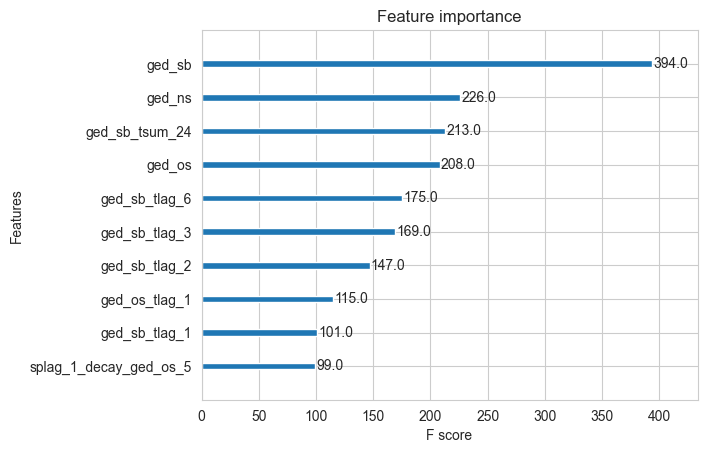

In [16]:
from xgboost import plot_importance

# plot
plot_importance(bst, max_num_features=10)


In [17]:
# print all feature importance sorted
feature_importance = bst.get_fscore()
feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
feature_importance

[('ged_sb', 394.0),
 ('ged_ns', 226.0),
 ('ged_sb_tsum_24', 213.0),
 ('ged_os', 208.0),
 ('ged_sb_tlag_6', 175.0),
 ('ged_sb_tlag_3', 169.0),
 ('ged_sb_tlag_2', 147.0),
 ('ged_os_tlag_1', 115.0),
 ('ged_sb_tlag_1', 101.0),
 ('splag_1_decay_ged_os_5', 99.0),
 ('acled_sb', 93.0),
 ('ged_sb_tlag_4', 90.0),
 ('decay_ged_ns_5', 87.0),
 ('splag_1_decay_ged_sb_5', 87.0),
 ('wdi_sp_urb_totl_in_zs', 82.0),
 ('ged_sb_tlag_5', 81.0),
 ('decay_acled_sb_5', 75.0),
 ('decay_ged_os_100', 74.0),
 ('decay_ged_ns_100', 59.0),
 ('wdi_sm_pop_refg_or', 54.0),
 ('wdi_se_enr_prim_fm_zs', 52.0),
 ('decay_ged_sb_500', 50.0),
 ('acled_os', 46.0),
 ('acled_sb_count', 42.0),
 ('decay_ged_sb_5', 41.0),
 ('wdi_ms_mil_xpnd_gd_zs', 40.0),
 ('splag_1_decay_ged_ns_5', 38.0),
 ('wdi_sp_pop_totl', 36.0),
 ('decay_ged_sb_100', 32.0),
 ('dam_cap_pcap_t48', 30.0),
 ('wdi_ag_lnd_frst_k2', 29.0),
 ('splag_wdi_sm_pop_netm', 28.0),
 ('wdi_sp_pop_grow', 27.0),
 ('wdi_sm_pop_netm', 26.0),
 ('decay_ged_os_5', 26.0),
 ('wdi_sl_tlf_

In [18]:
# for each timeseries plot the actual and predicted values
import matplotlib.pyplot as plt
# map back id to country name
# country_id = index + 1
# y_test.reset_index(inplace=True, drop=True)
# y_test = y_test.to_frame()
# y_test['country_id'] = y_test.index + 1



In [19]:
# map country_id to country name
# country_list = pd.read_csv('data/country_list.csv') 
# country_list
# y_test["country_name"] = y_test["country_id"].map(country_list.set_index('country_id')['name'])
# y_test

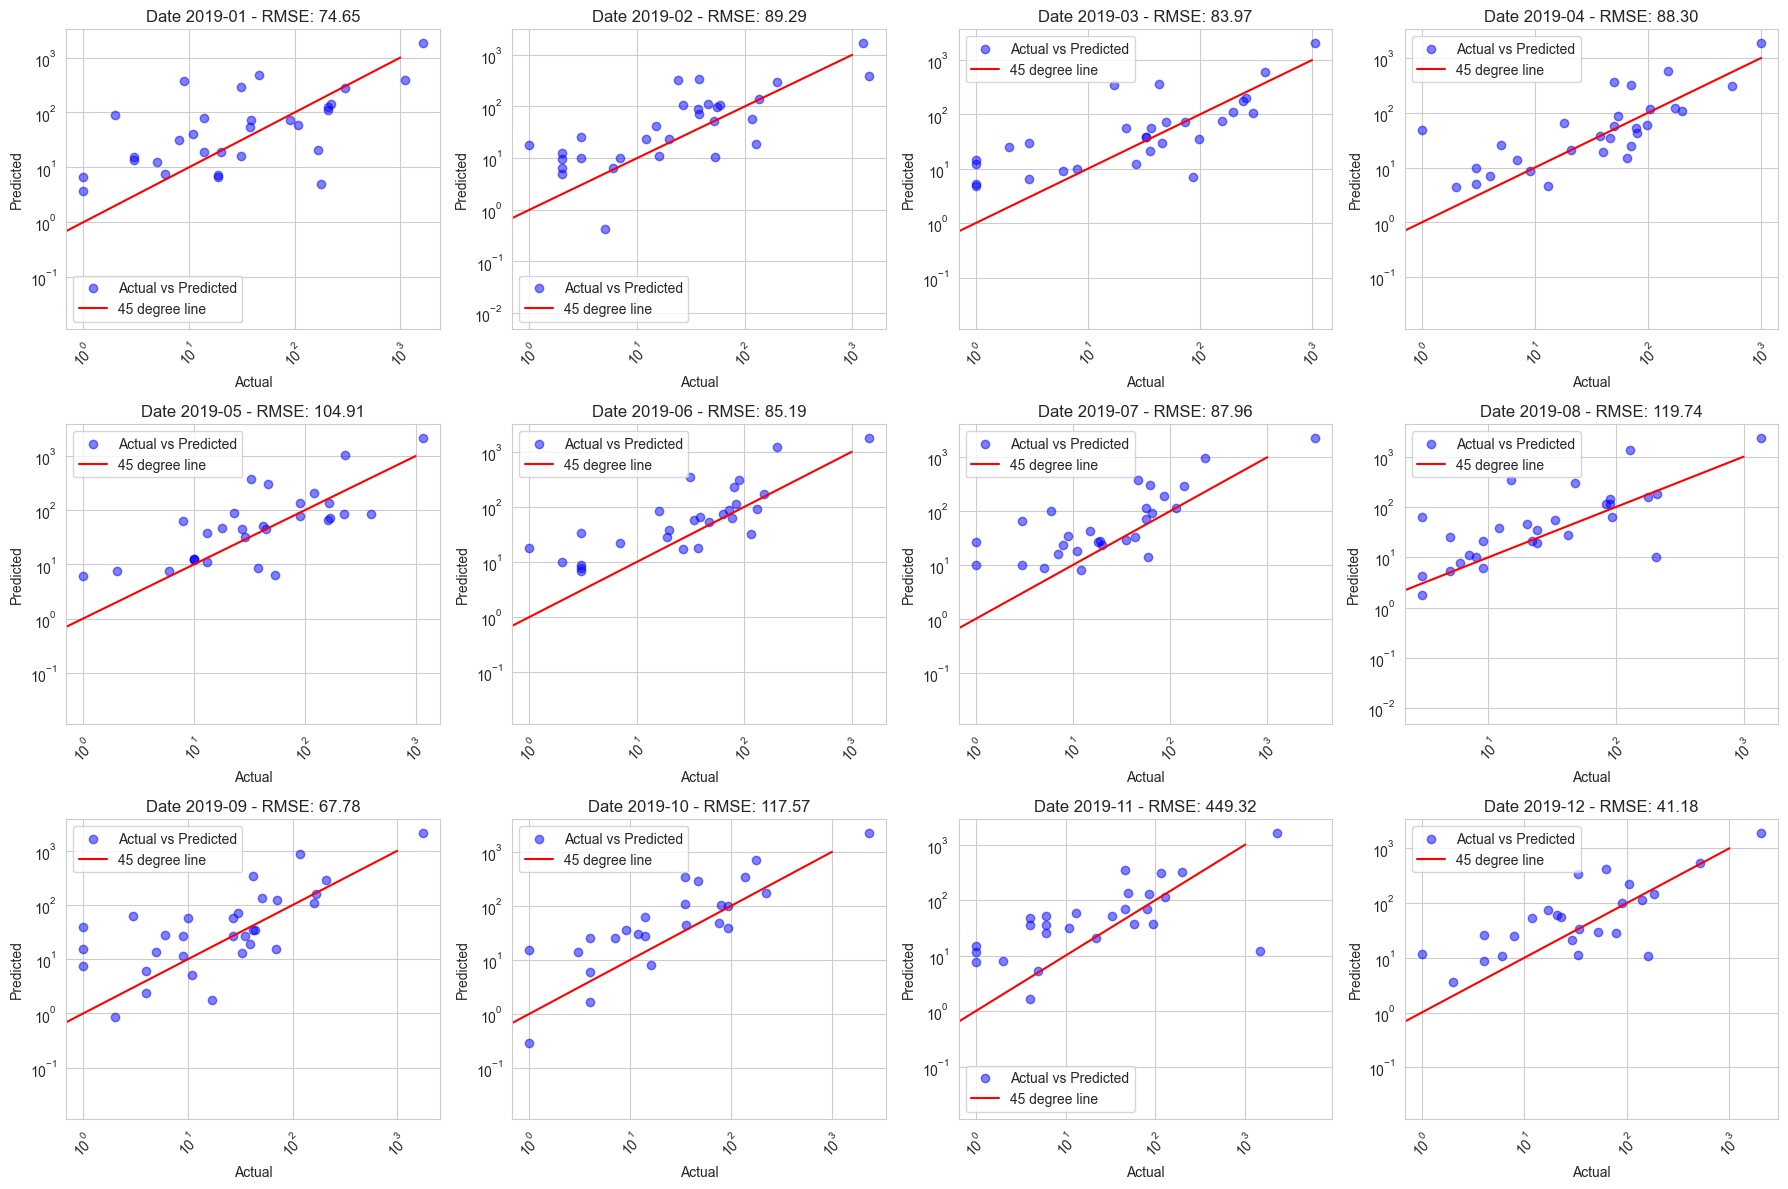

In [20]:
# get all unique months sorted from test_df
# test_df['month_id'].unique()
# # get target and predictions for each month
# for month_id in test_df['month_id'].unique():
#     # get target and predictions for each month
#     target_month = test_df[test_df['month_id'] == month_id][target]
#     predictions_month = test_df[test_df['month_id'] == month_id]['predictions']
#     # plot actual vs predicted for each month
#     plt.figure(figsize=(10, 6))
#     plt.scatter(target_month, predictions_month, color='blue', label='Actual', alpha=0.5)
#     plt.title(f'Actual vs Predicted Values for month {month_id}')
#     plt.xlabel('Actual')
#     plt.ylabel('Predicted')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.plot([0, 1000], [0, 1000], color='red', label='45 degree line')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

import matplotlib.pyplot as plt

# Assuming test_df is your DataFrame, and 'target' and 'predictions' are columns in it
unique_months = test_df['month_id'].unique()
n_months = len(unique_months)

# Calculate the grid size for the subplot (simple square root approximation for a square grid)
grid_size_x = int(n_months ** 0.5) + (1 if n_months % int(n_months ** 0.5) else 0)
grid_size_y = grid_size_x + 1

# print(f'Grid size: {grid_size}')
# Set overall figure size
plt.figure(figsize=(grid_size_x * 6, grid_size_y * 3))  # Adjust the size factors (6, 4) based on your preference

for index, month_id in enumerate(unique_months, start=1):
    this_month = test_df[test_df['month_id'] == month_id]
    mean_sq_error = sqrt(mean_squared_error(this_month[target], this_month['predictions']))
    current_date = this_month["date"].iloc[0]
    target_month = this_month[target]
    predictions_month = this_month['predictions']

    # Create subplot for current month
    plt.subplot(grid_size_x, grid_size_y, index)
    plt.scatter(target_month, predictions_month, color='blue', label='Actual vs Predicted', alpha=0.5)
    # print current_date in YY/MM format
    print_date = current_date.strftime('%Y-%m')
    plt.title(f'Date {print_date} - RMSE: {mean_sq_error:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.xscale('log')
    plt.yscale('log')
    plt.plot([0, 1000], [0, 1000], color='red', label='45 degree line')
    plt.legend()
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [21]:
# plot series of actual vs predicted for each country
# country_ids = test_df['country_id'].unique().tolist()[:1]
# # remove country id if it 
# 
# 
# for country_id in country_ids:
#     # get target and predictions for each country
#     this_country = test_df[test_df['country_id'] == country_id]
#     # this_country.reset_index(inplace=True, drop=True)
#     target_country = this_country[target]
#     predictions_country = this_country['predictions']
#     # plot actual vs predicted for each country
#     plt.figure(figsize=(10, 6))
#     # plot train set actual
#     plt.plot(train_df[train_df['country_id'] == country_id]['y_shifted'], label='Train', color='green')
# 
#     plt.plot(target_country, label='Actual', color='blue')
#     plt.plot(predictions_country, label='Predicted', color='red')
#     # set x as date according to the month_id
#     # plt.xticks(cm_features[cm_features['country_id'] == country_id]['month_id'], cm_features[cm_features['country_id'] == country_id]['date'], rotation=45)
#     plt.xlabel('date')
#     plt.ylabel('Ged_sb')
#     plt.legend()
#     # plt.xlim(0, len(this_country['date']))
#     plt.title(f'Actual vs Predicted Values for country {country_id}')
#     plt.show()


Skipping Guyana as all actuals are 0
Skipping Suriname as all actuals are 0
Skipping Trinidad and Tobago as all actuals are 0
Skipping Venezuela as all actuals are 0
Skipping Samoa as all actuals are 0
Skipping Tonga as all actuals are 0
Skipping Argentina as all actuals are 0
Skipping Bolivia as all actuals are 0
Skipping Brazil as all actuals are 0
Skipping Chile as all actuals are 0
Skipping Ecuador as all actuals are 0
Skipping Paraguay as all actuals are 0


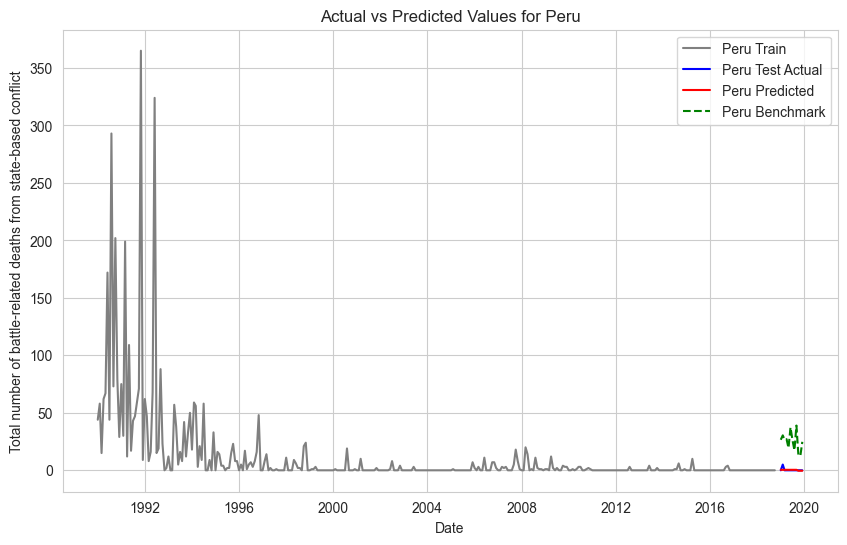

Skipping Uruguay as all actuals are 0
Skipping Guatemala as all actuals are 0
Skipping Mexico as all actuals are 0
Skipping Barbados as all actuals are 0
Skipping Dominica as all actuals are 0
Skipping Grenada as all actuals are 0
Skipping St. Lucia as all actuals are 0
Skipping St. Vincent and the Grenadines as all actuals are 0
Skipping Dominican Republic as all actuals are 0
Skipping Haiti as all actuals are 0
Skipping Jamaica as all actuals are 0
Skipping Bahamas as all actuals are 0
Skipping Belize as all actuals are 0


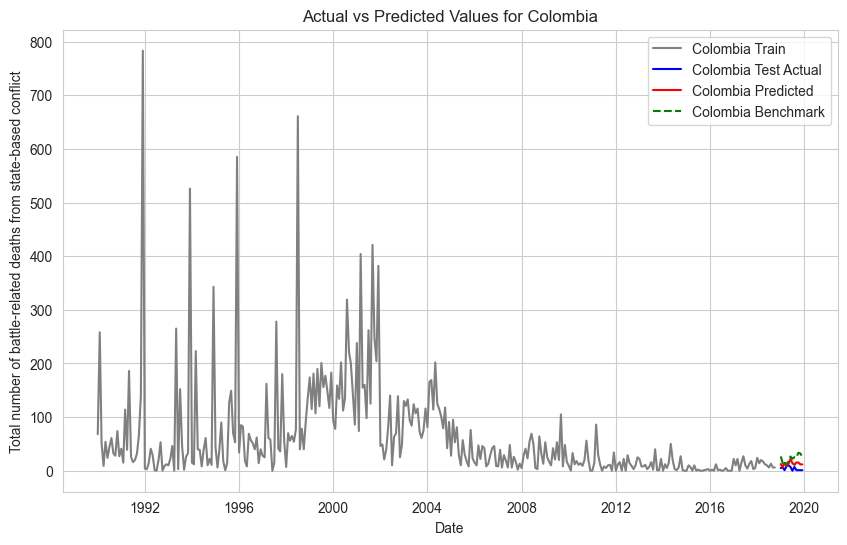

Skipping Costa Rica as all actuals are 0
Skipping Cuba as all actuals are 0
Skipping El Salvador as all actuals are 0
Skipping Honduras as all actuals are 0
Skipping Nicaragua as all actuals are 0
Skipping Panama as all actuals are 0
Skipping Antigua and Barbuda as all actuals are 0
Skipping St. Kitts and Nevis as all actuals are 0
Skipping Iceland as all actuals are 0
Skipping Ireland as all actuals are 0
Skipping United Kingdom as all actuals are 0
Skipping Cape Verde as all actuals are 0
Skipping Cote d'Ivoire as all actuals are 0
Skipping Ghana as all actuals are 0
Skipping Liberia as all actuals are 0
Skipping Portugal as all actuals are 0
Skipping Spain as all actuals are 0


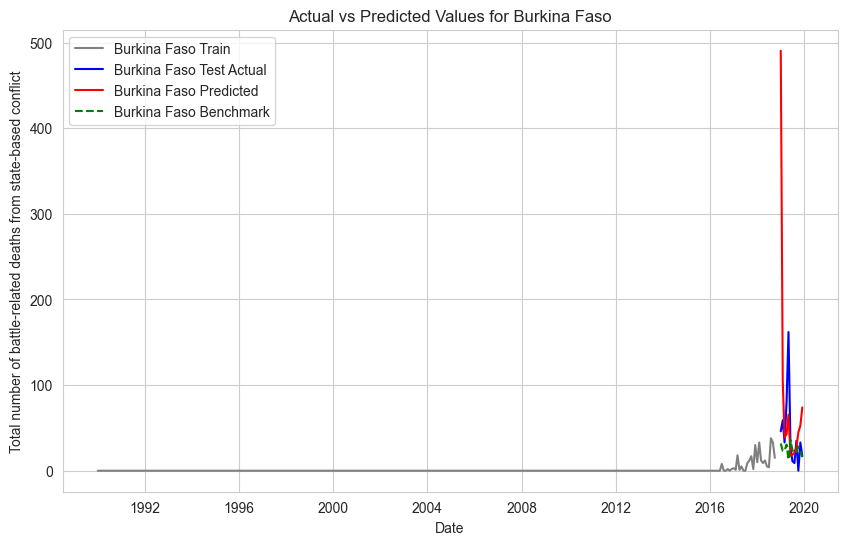

Skipping Guinea as all actuals are 0
Skipping Guinea-Bissau as all actuals are 0


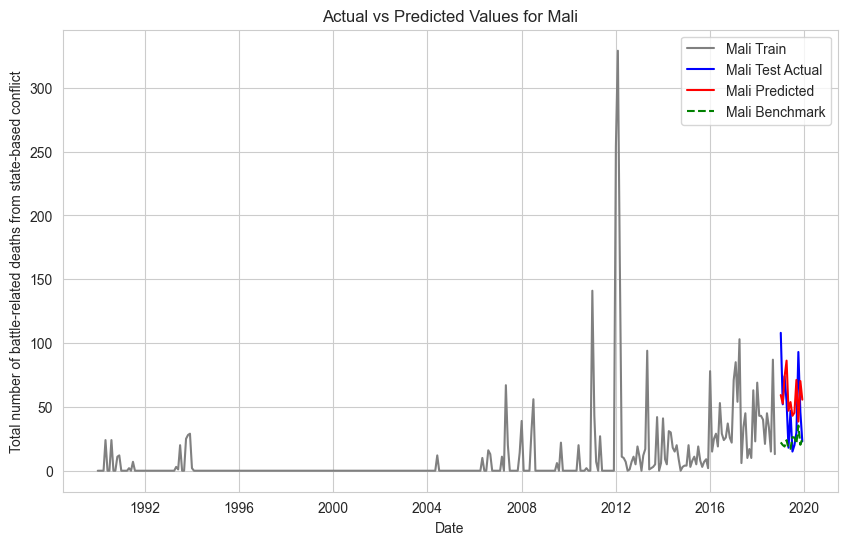

Skipping Senegal as all actuals are 0
Skipping Sierra Leone as all actuals are 0
Skipping The Gambia as all actuals are 0
Skipping Djibouti as all actuals are 0
Skipping Eritrea as all actuals are 0


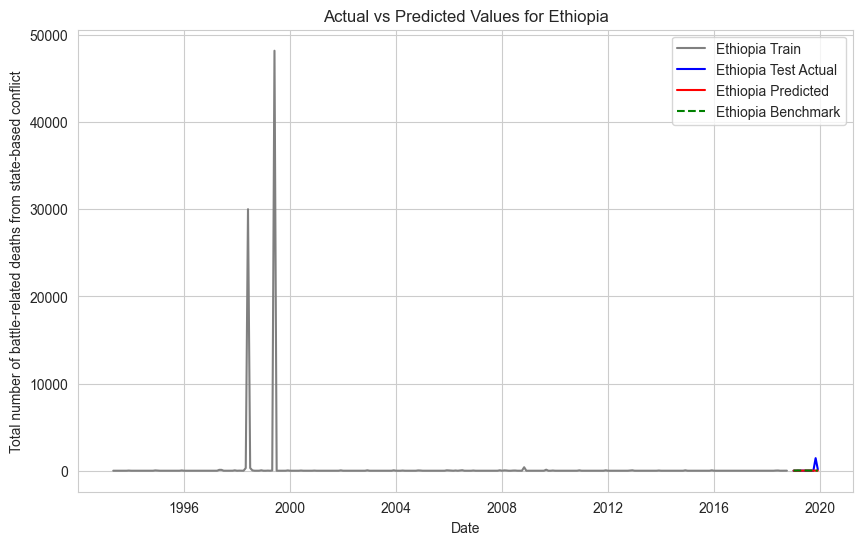

Skipping Mongolia as all actuals are 0


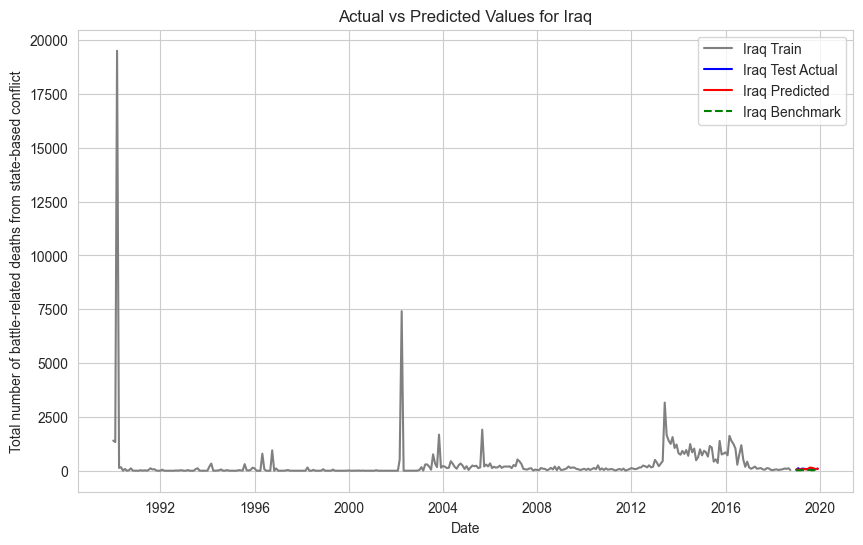

Skipping Jordan as all actuals are 0
Skipping Kazakhstan as all actuals are 0
Skipping Norway as all actuals are 0


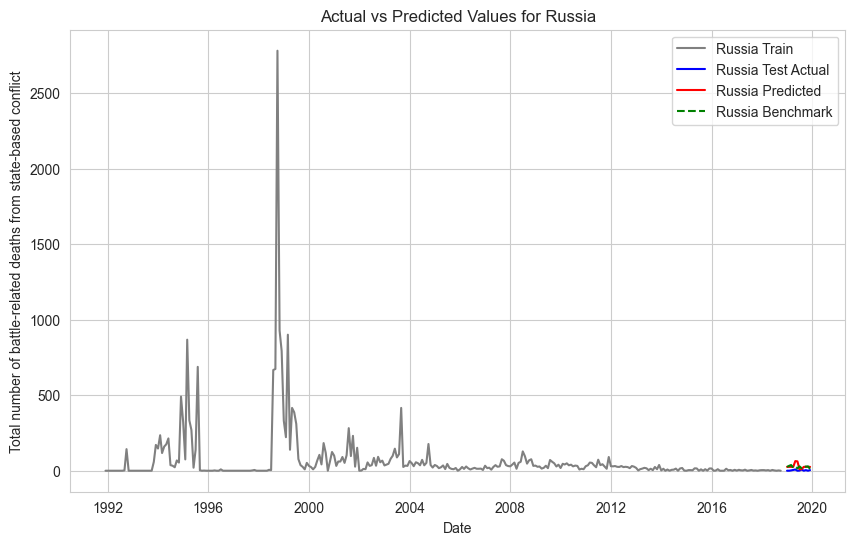

Skipping Sweden as all actuals are 0


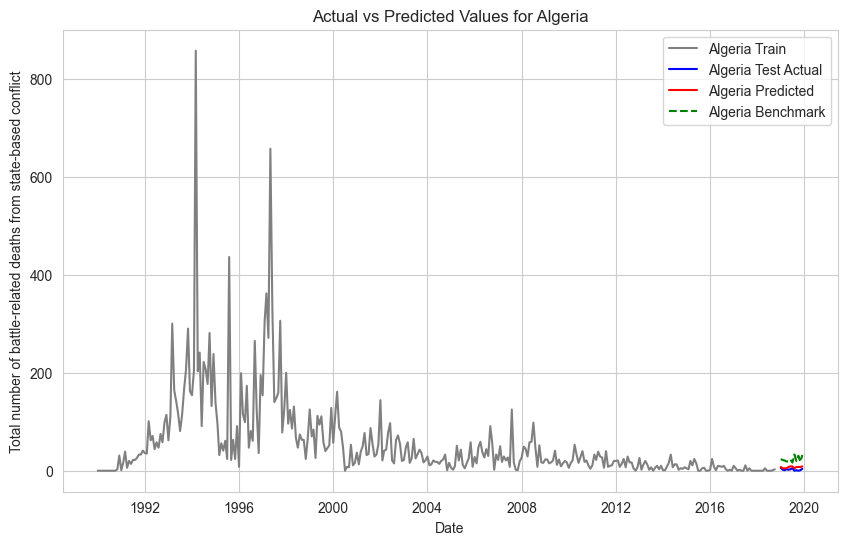

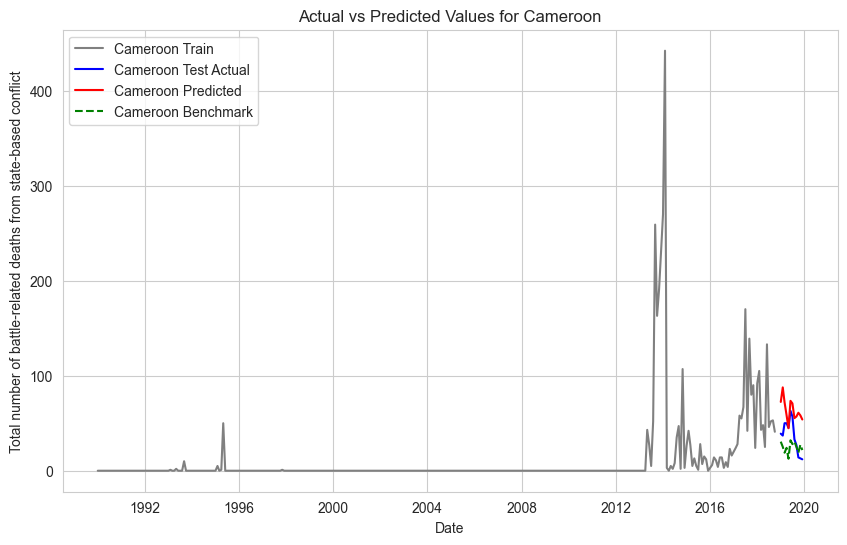

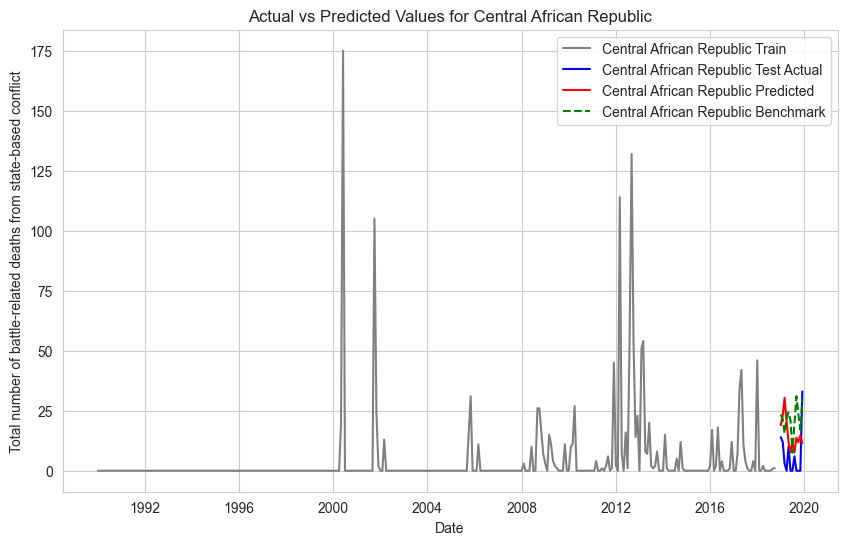

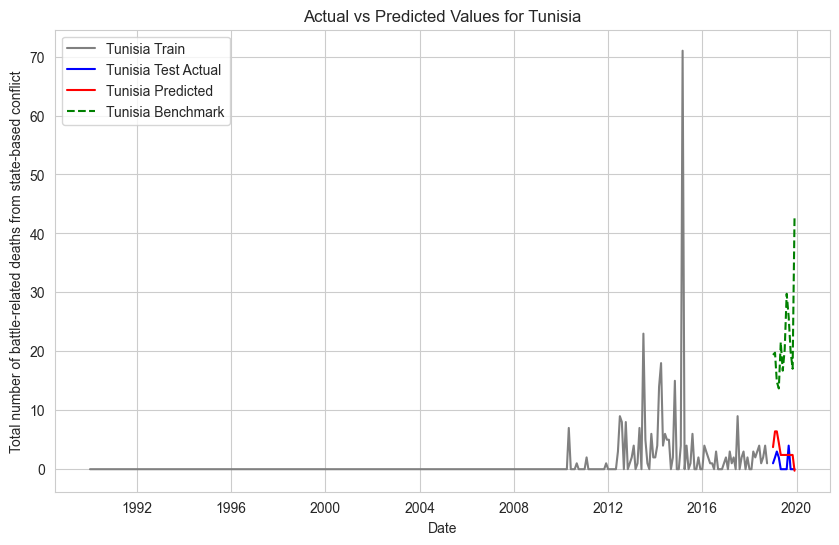

Skipping Benin as all actuals are 0
Skipping Equatorial Guinea as all actuals are 0
Skipping Kiribati as all actuals are 0


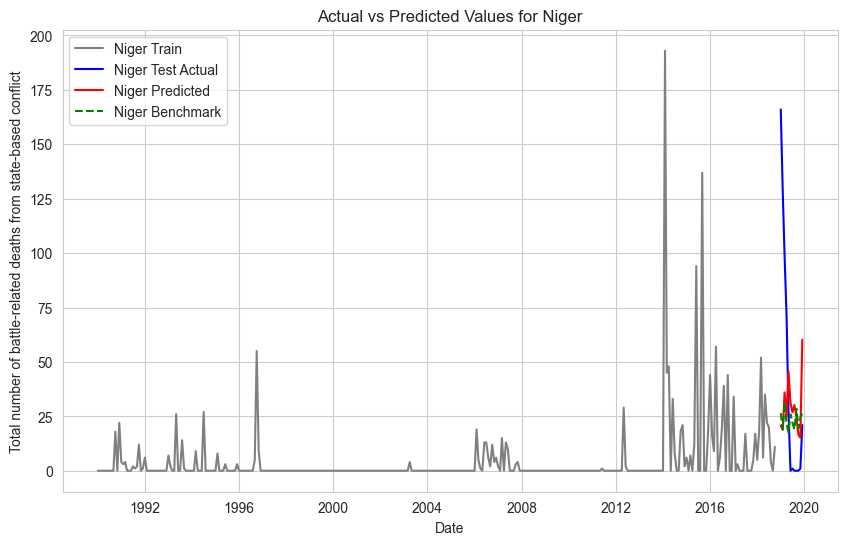

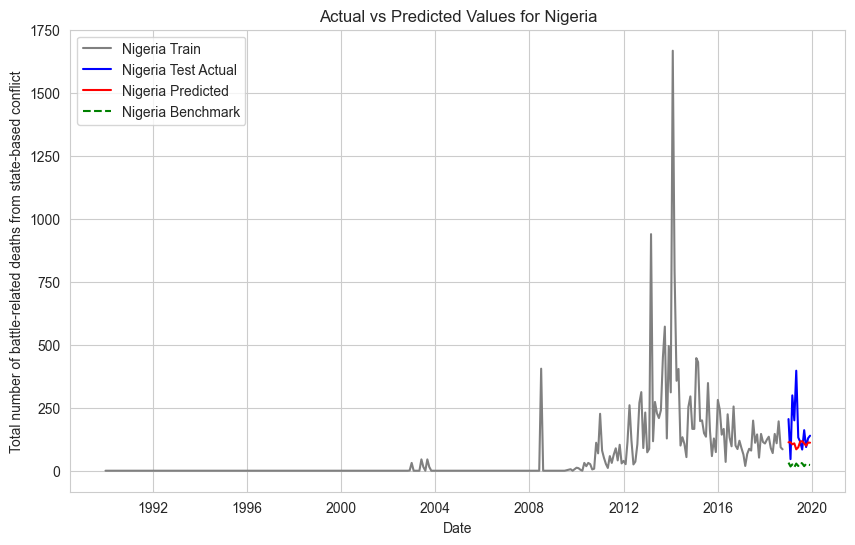

Skipping Sao Tome and Principe as all actuals are 0
Skipping Togo as all actuals are 0
Skipping Albania as all actuals are 0
Skipping Bosnia and Herzegovina as all actuals are 0
Skipping Croatia as all actuals are 0
Skipping Italy as all actuals are 0
Skipping Macedonia as all actuals are 0
Skipping Malta as all actuals are 0
Skipping Bulgaria as all actuals are 0
Skipping Cyprus as all actuals are 0
Skipping Georgia as all actuals are 0
Skipping Greece as all actuals are 0


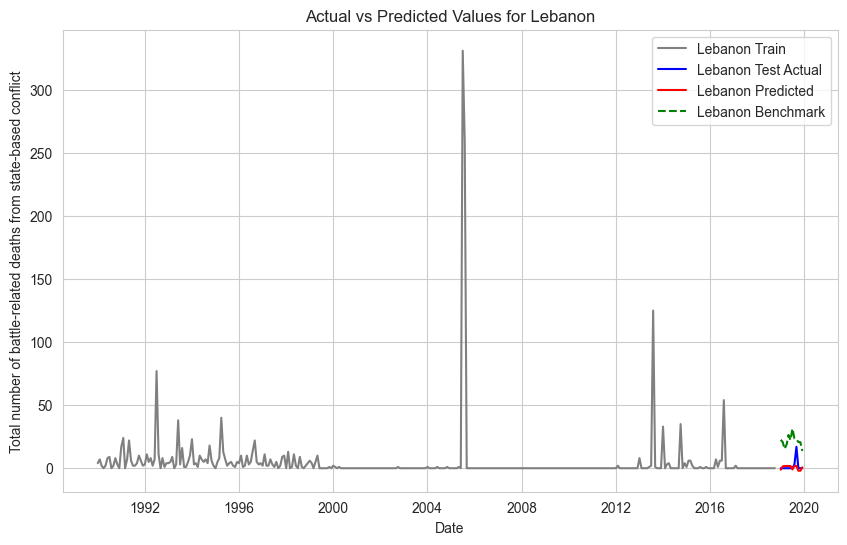

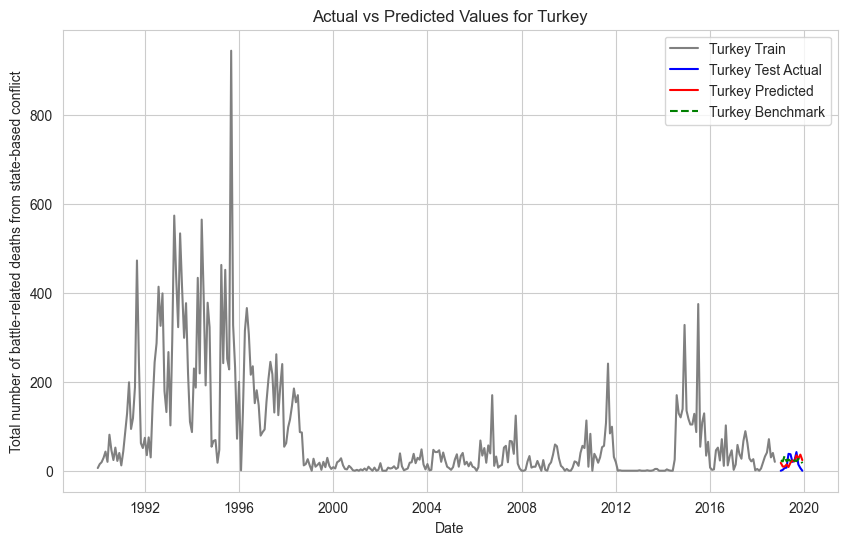

Skipping Austria as all actuals are 0
Skipping Czech Republic as all actuals are 0
Skipping Denmark as all actuals are 0
Skipping Hungary as all actuals are 0
Skipping Poland as all actuals are 0
Skipping Slovakia as all actuals are 0
Skipping Slovenia as all actuals are 0
Skipping Belgium as all actuals are 0
Skipping France as all actuals are 0
Skipping Luxembourg as all actuals are 0
Skipping Netherlands as all actuals are 0
Skipping Switzerland as all actuals are 0
Skipping Belarus as all actuals are 0
Skipping Estonia as all actuals are 0
Skipping Finland as all actuals are 0
Skipping Latvia as all actuals are 0
Skipping Lithuania as all actuals are 0
Skipping Moldova as all actuals are 0
Skipping Romania as all actuals are 0


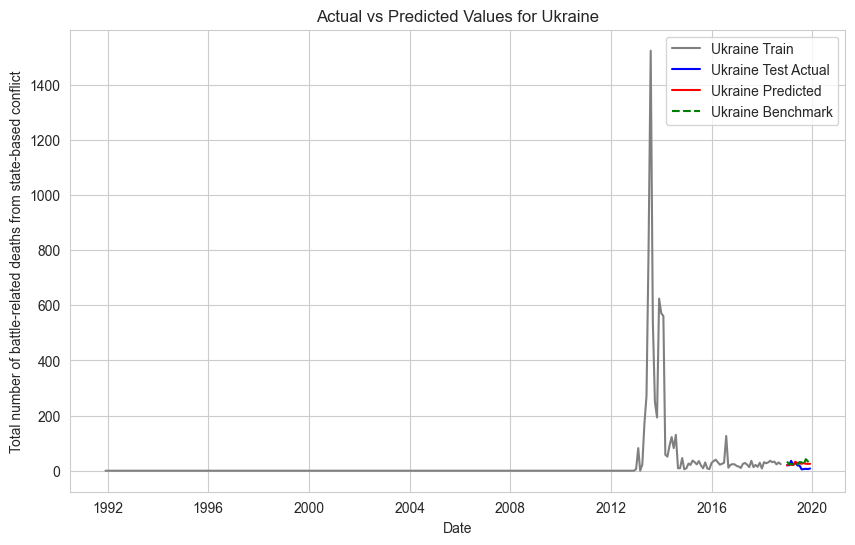

Skipping Maldives as all actuals are 0
Skipping Oman as all actuals are 0


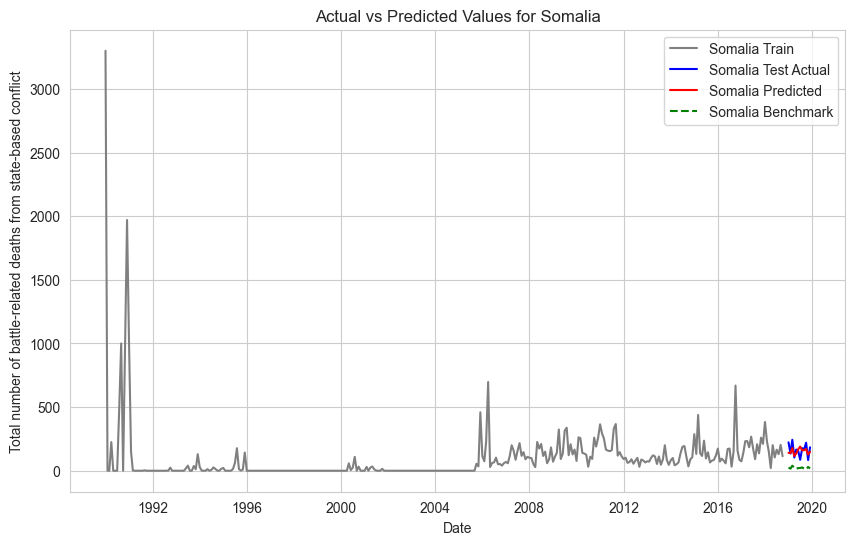

Skipping Sri Lanka as all actuals are 0
Skipping Turkmenistan as all actuals are 0
Skipping Uzbekistan as all actuals are 0


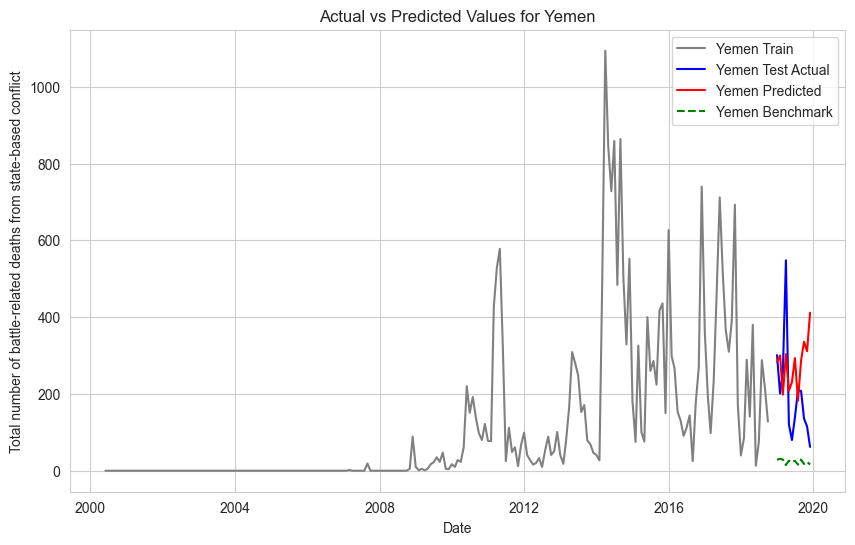

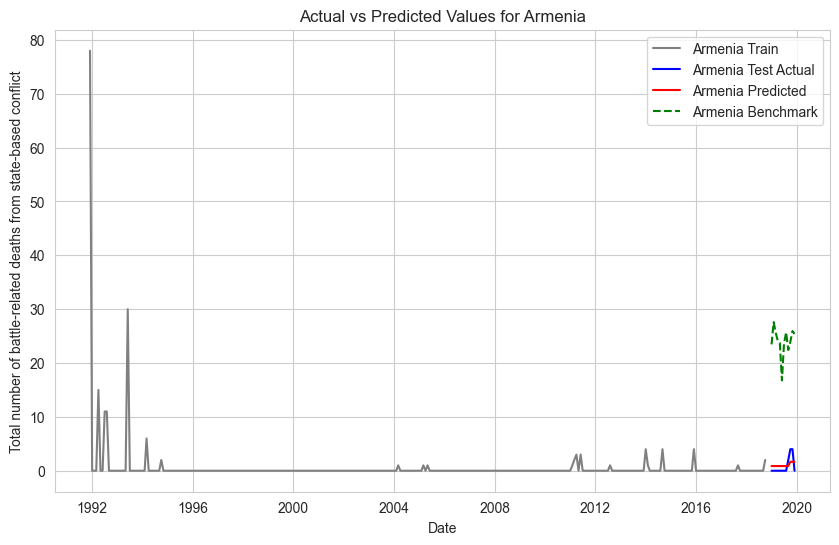

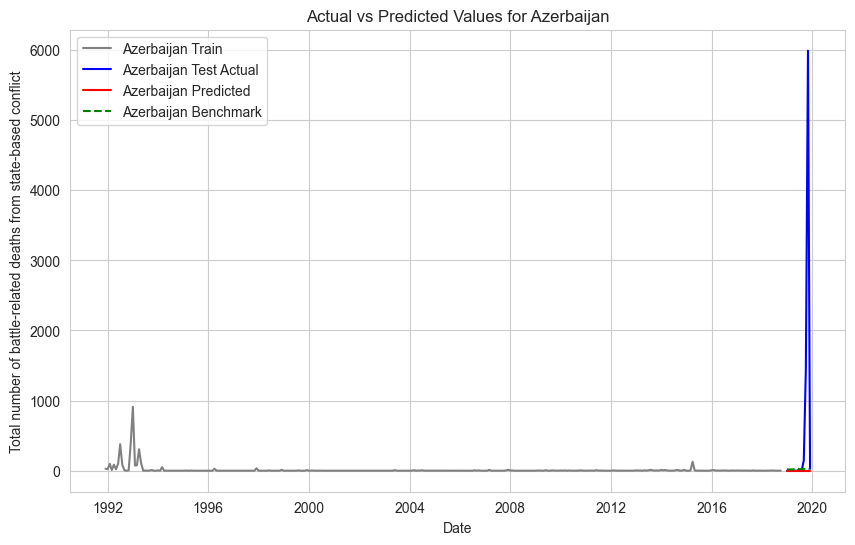

Skipping Bahrain as all actuals are 0


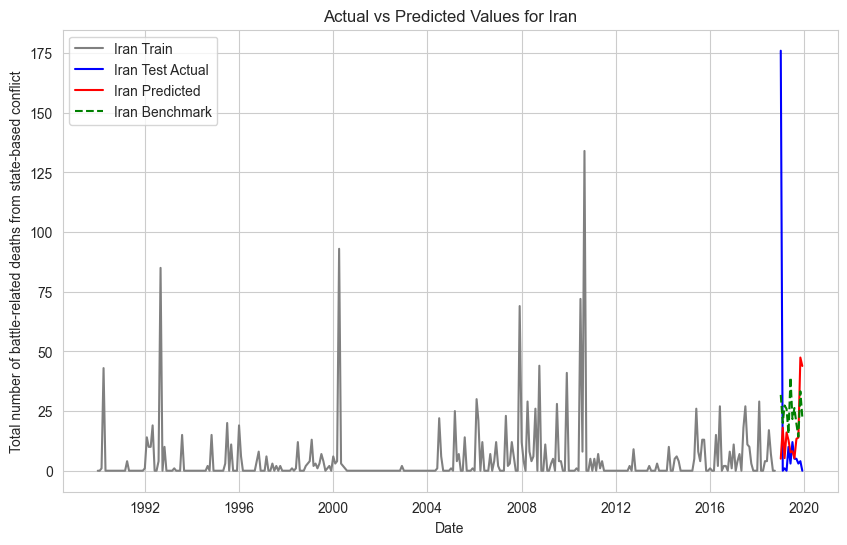

Skipping Kuwait as all actuals are 0
Skipping Qatar as all actuals are 0
Skipping Saudi Arabia as all actuals are 0
Skipping United Arab Emirates as all actuals are 0


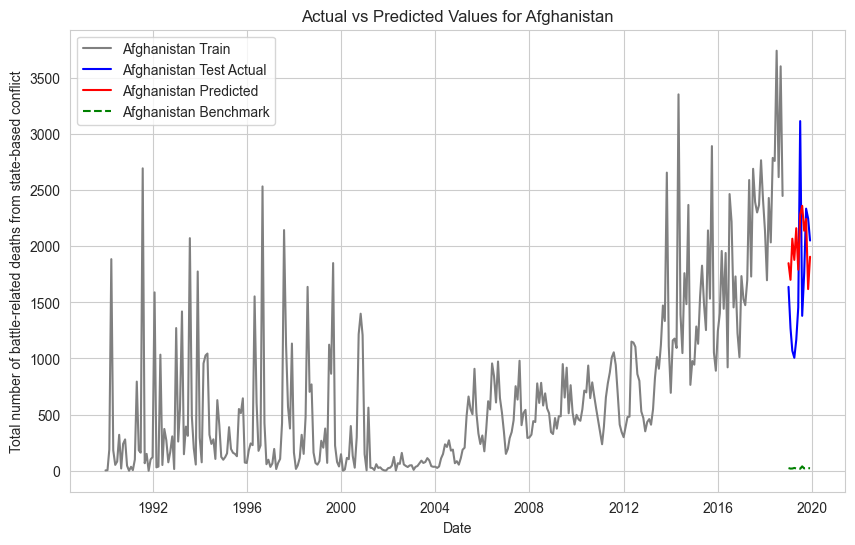

Skipping Kyrgyzstan as all actuals are 0
Skipping Nepal as all actuals are 0


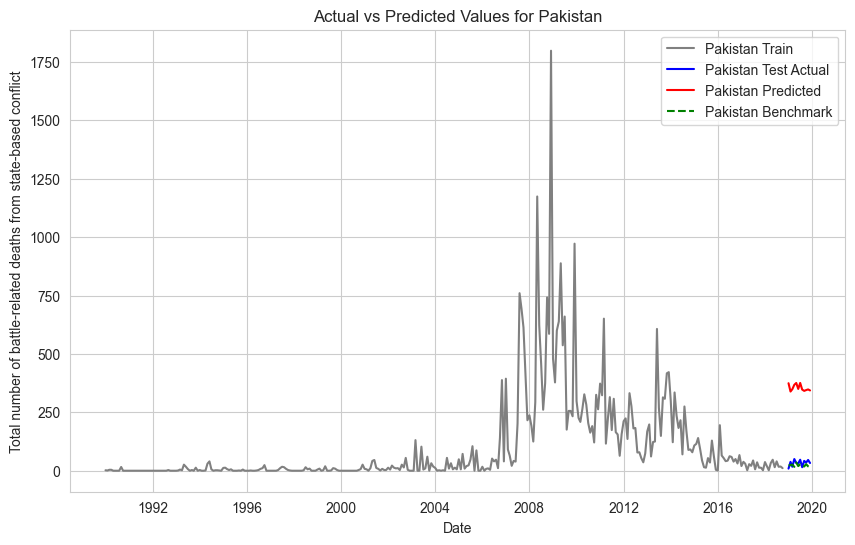

Skipping Tajikistan as all actuals are 0


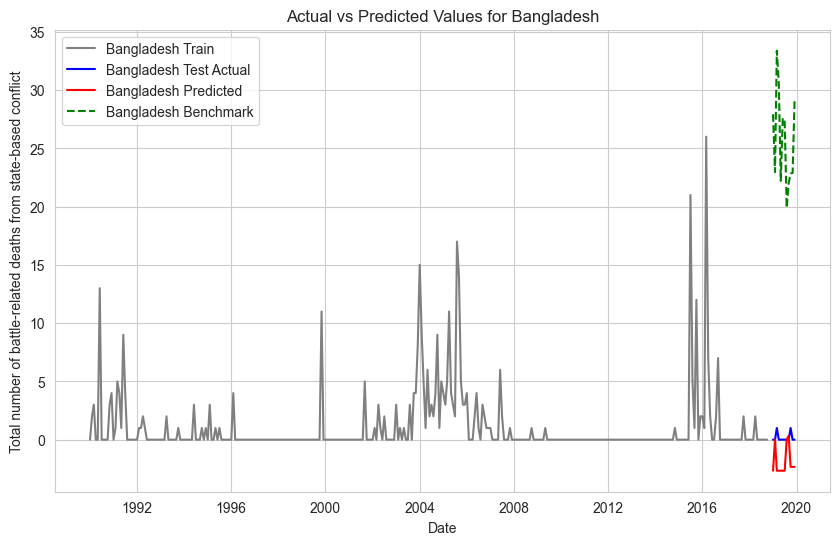

Skipping Bhutan as all actuals are 0
Skipping Brunei as all actuals are 0
Skipping Japan as all actuals are 0
Skipping North Korea as all actuals are 0
Skipping Palau as all actuals are 0


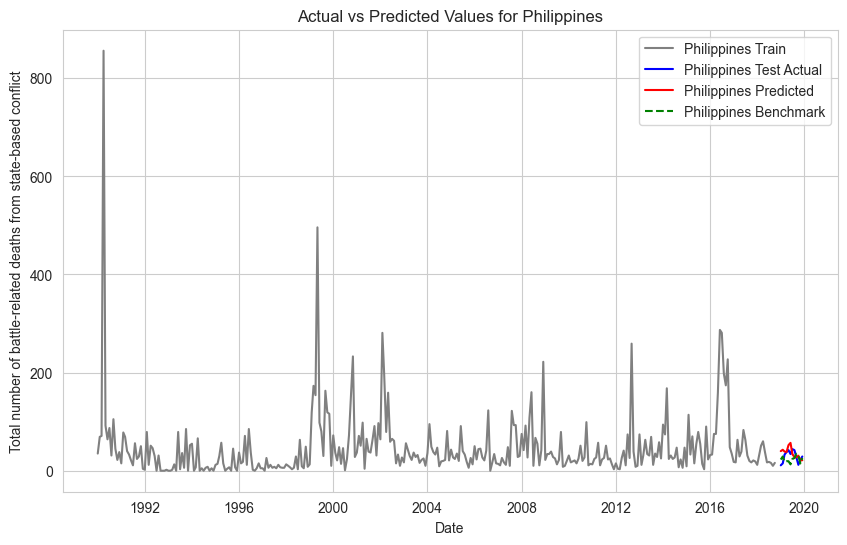

Skipping South Korea as all actuals are 0
Skipping Cambodia as all actuals are 0
Skipping Laos as all actuals are 0


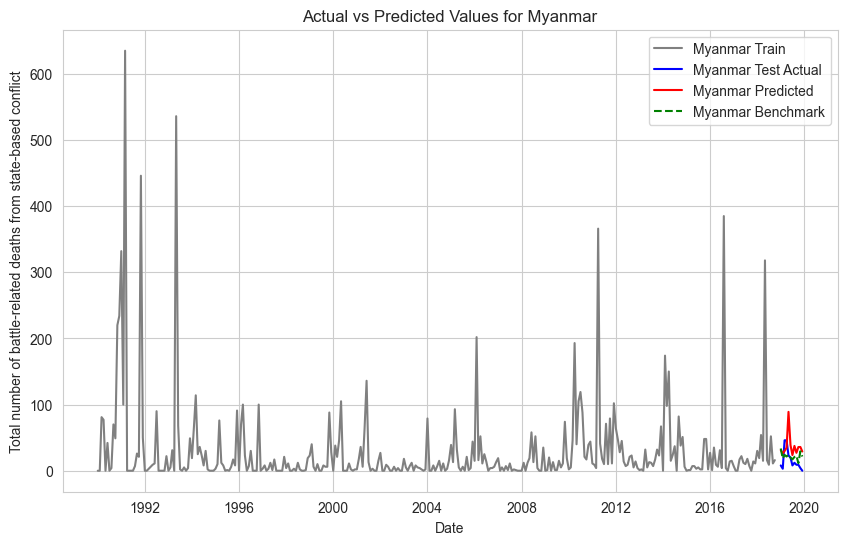

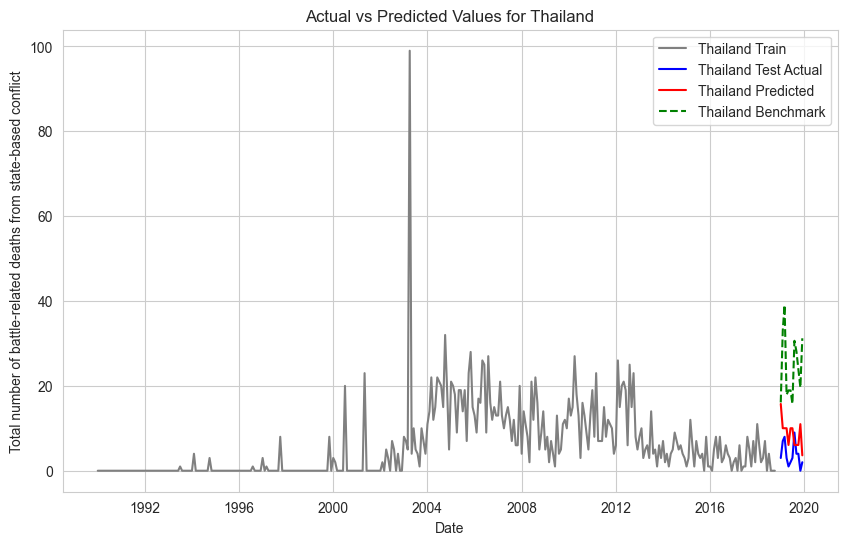

Skipping Vietnam as all actuals are 0
Skipping Marshall Is. as all actuals are 0
Skipping Micronesia as all actuals are 0
Skipping Botswana as all actuals are 0


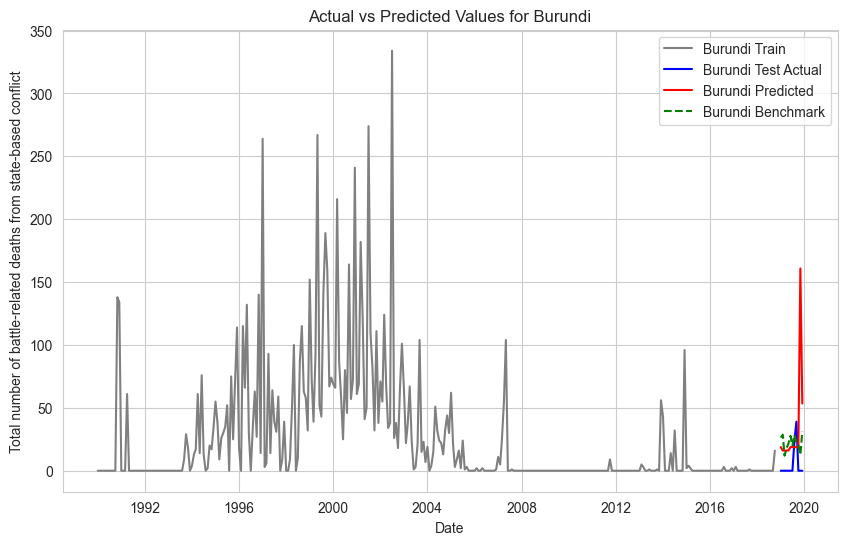

Skipping Rwanda as all actuals are 0
Skipping Zambia as all actuals are 0
Skipping Zimbabwe as all actuals are 0
Skipping Comoros as all actuals are 0
Skipping Lesotho as all actuals are 0
Skipping Malawi as all actuals are 0


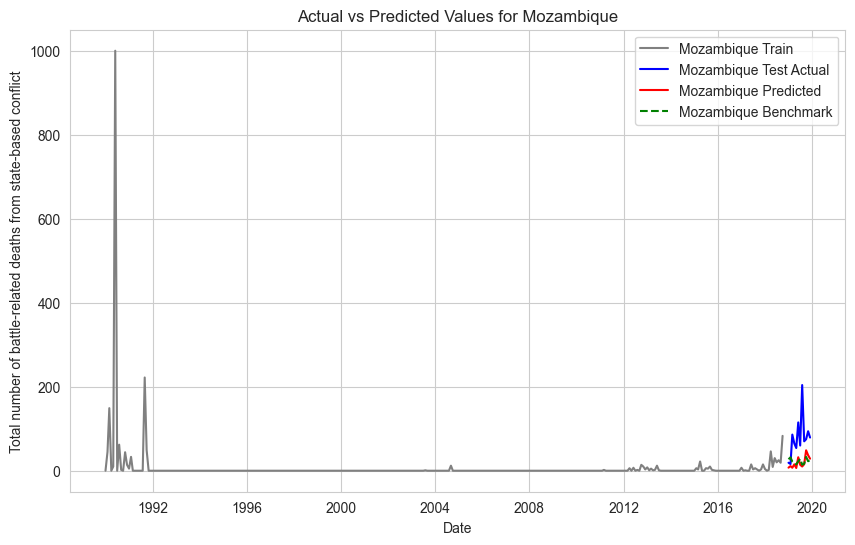

Skipping South Africa as all actuals are 0
Skipping Swaziland as all actuals are 0


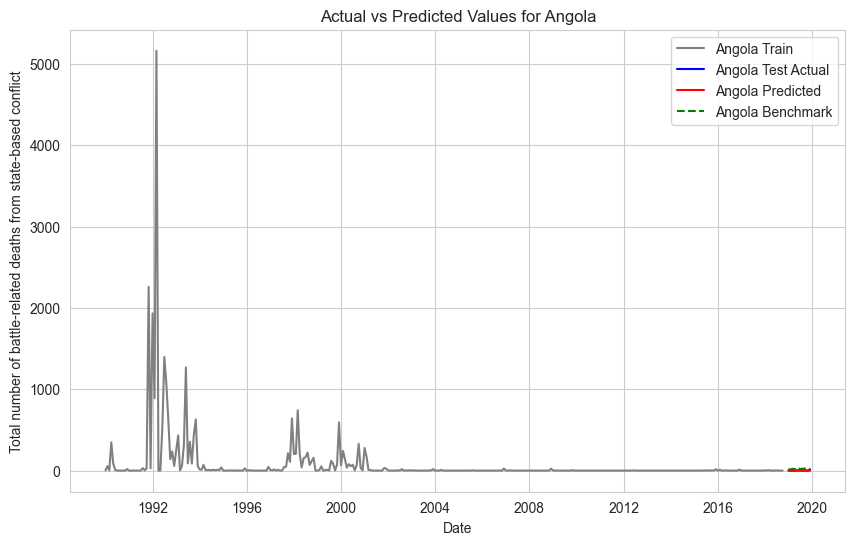

Skipping Congo as all actuals are 0


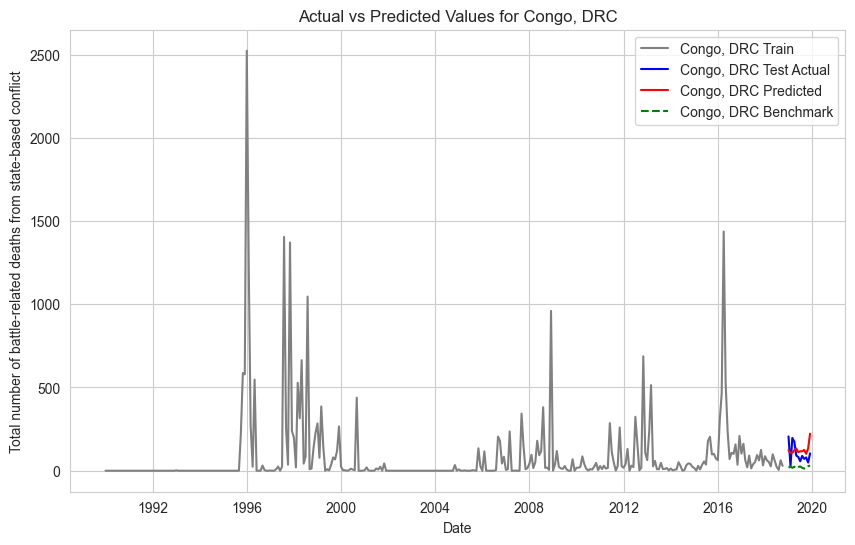

Skipping Fiji as all actuals are 0
Skipping Gabon as all actuals are 0
Skipping Namibia as all actuals are 0
Skipping New Zealand as all actuals are 0
Skipping Madagascar as all actuals are 0
Skipping Mauritius as all actuals are 0
Skipping Seychelles as all actuals are 0
Skipping Timor Leste as all actuals are 0
Skipping Australia as all actuals are 0
Skipping Nauru as all actuals are 0
Skipping Papua New Guinea as all actuals are 0
Skipping Solomon Is. as all actuals are 0
Skipping Tuvalu as all actuals are 0
Skipping Vanuatu as all actuals are 0
Skipping Canada as all actuals are 0
Skipping Germany as all actuals are 0
Skipping Taiwan as all actuals are 0
Skipping China as all actuals are 0
Skipping Malaysia as all actuals are 0
Skipping Singapore as all actuals are 0


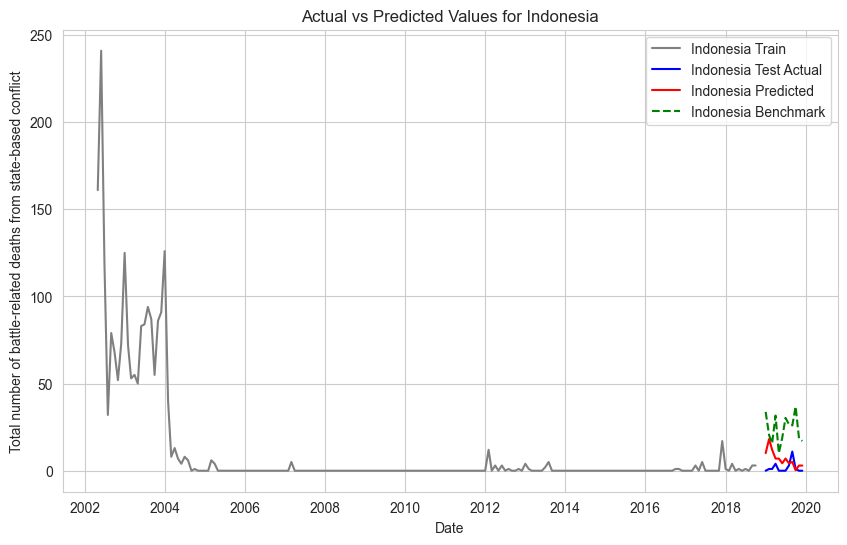

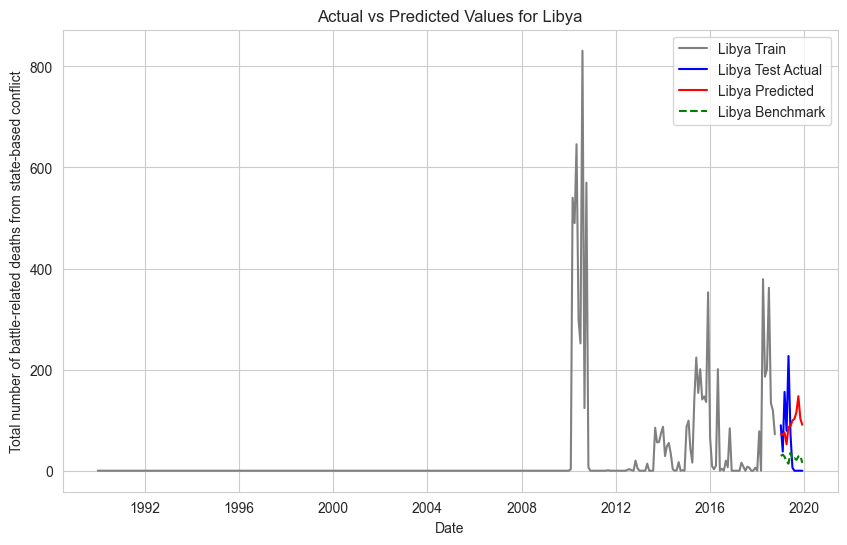

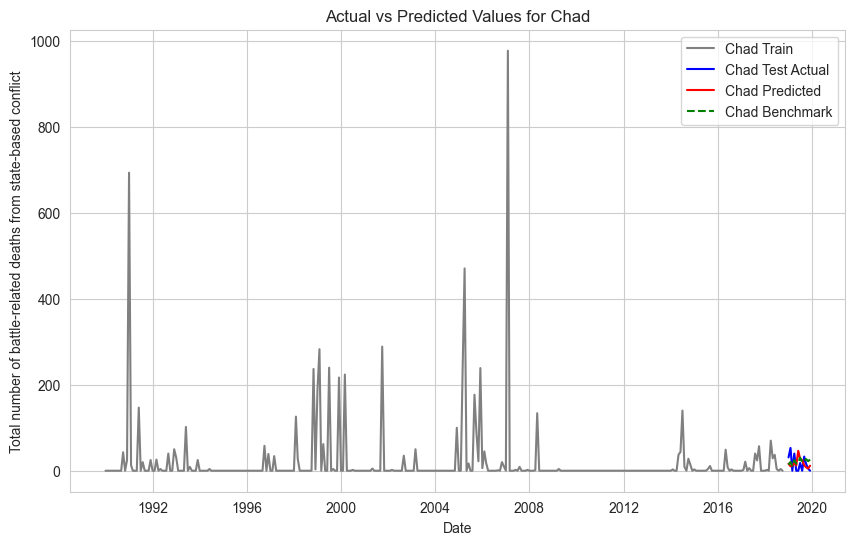

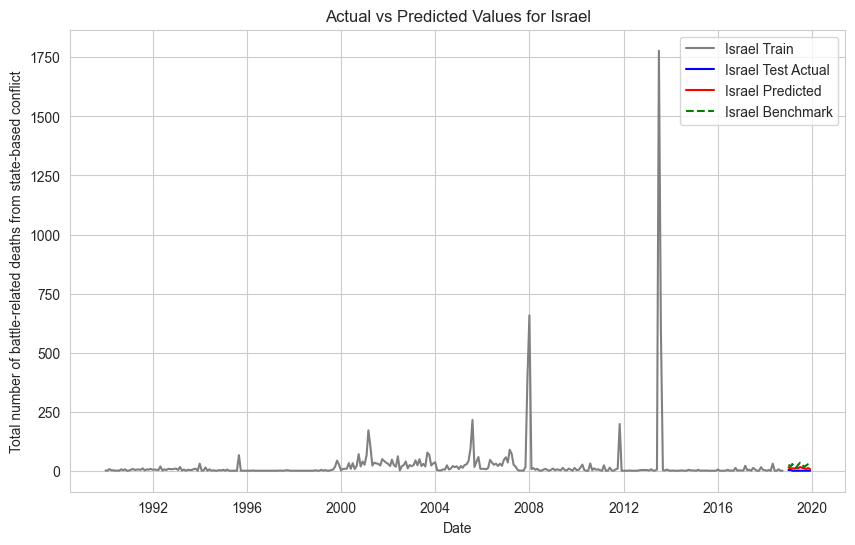

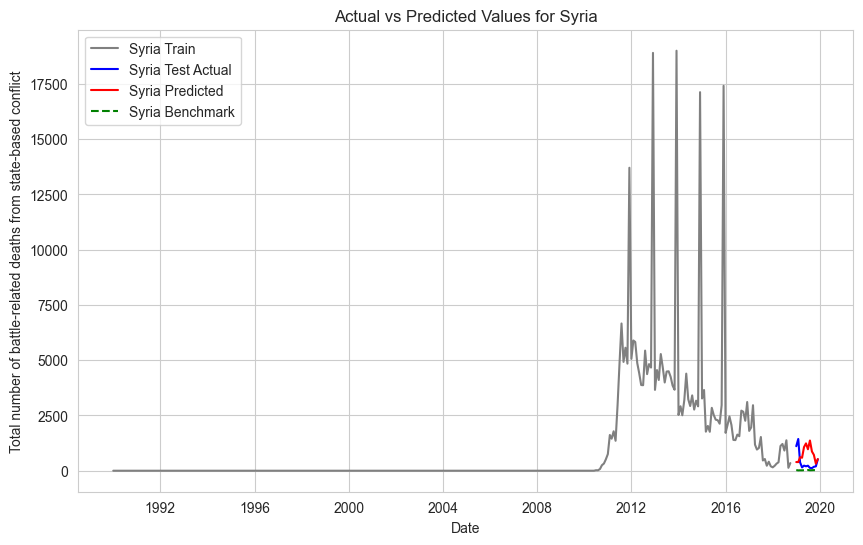

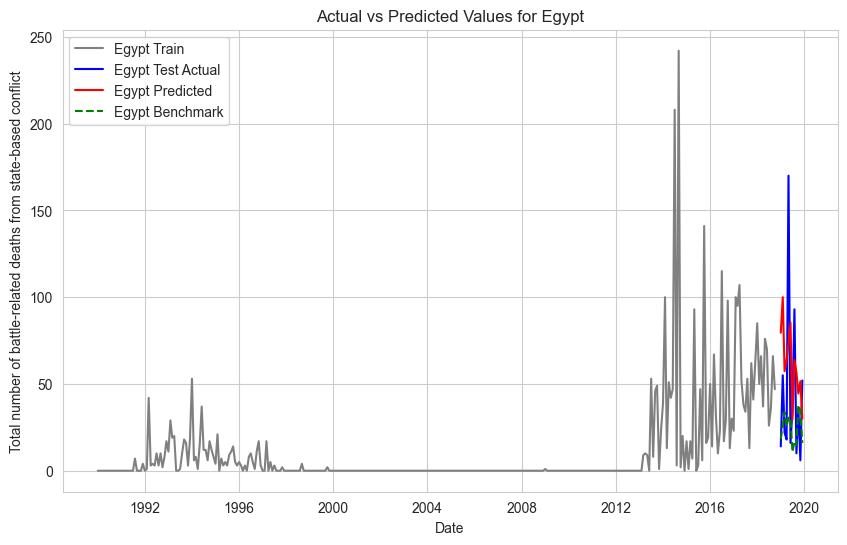

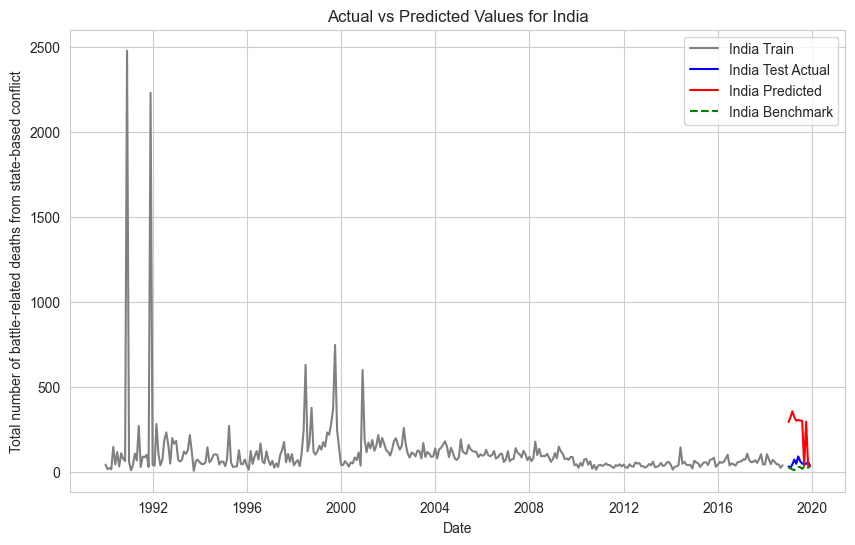

Skipping Montenegro as all actuals are 0
Skipping Kosovo as all actuals are 0
Skipping Serbia as all actuals are 0
Skipping United States as all actuals are 0
Skipping Uganda as all actuals are 0


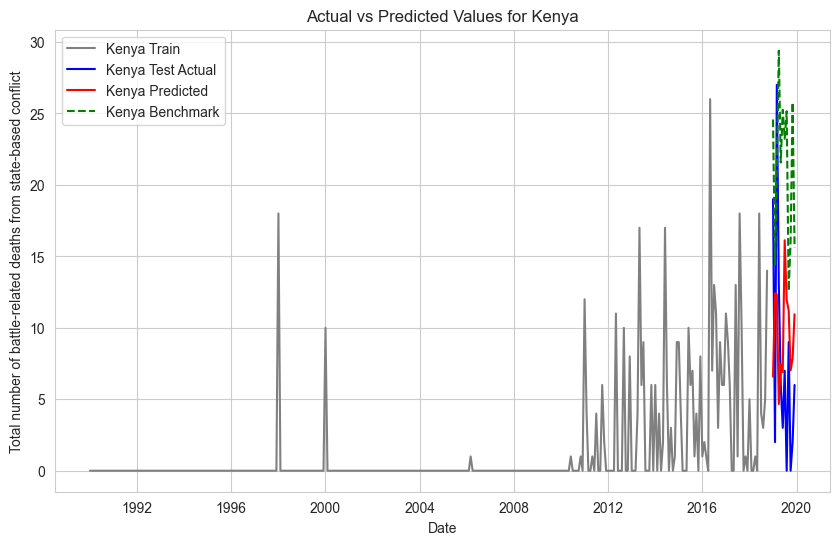

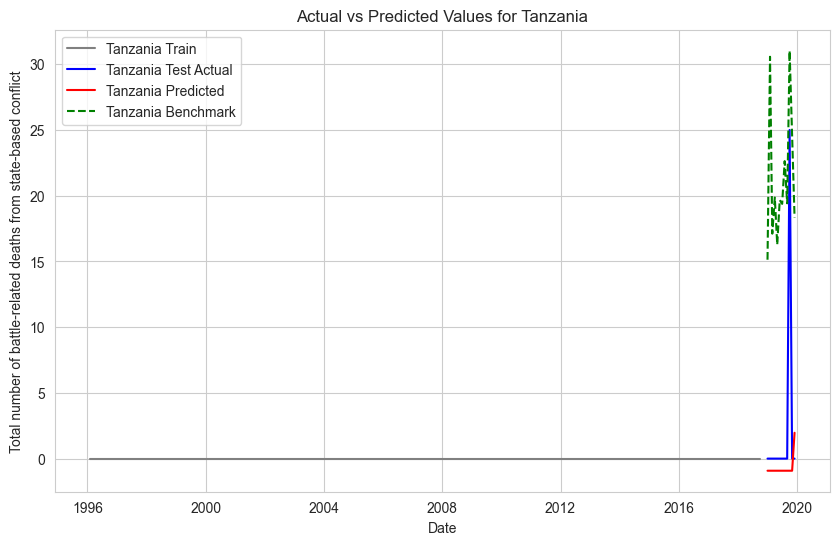

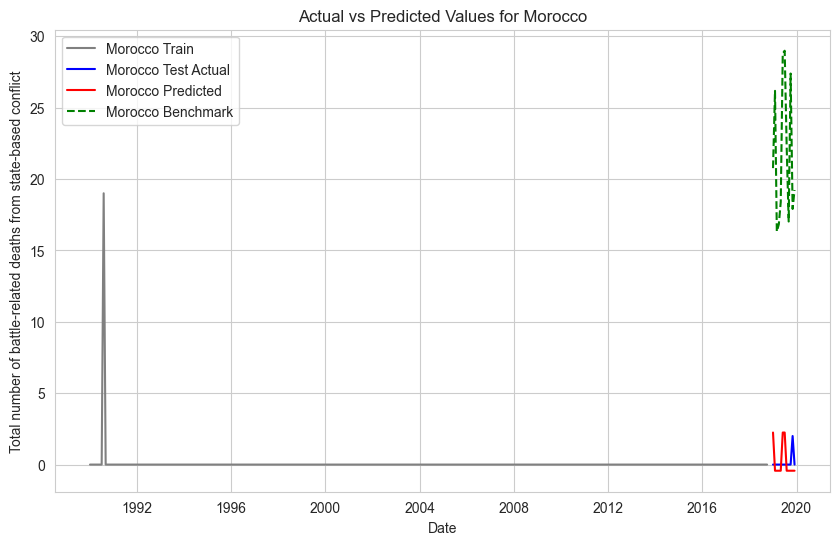

Skipping Mauritania as all actuals are 0


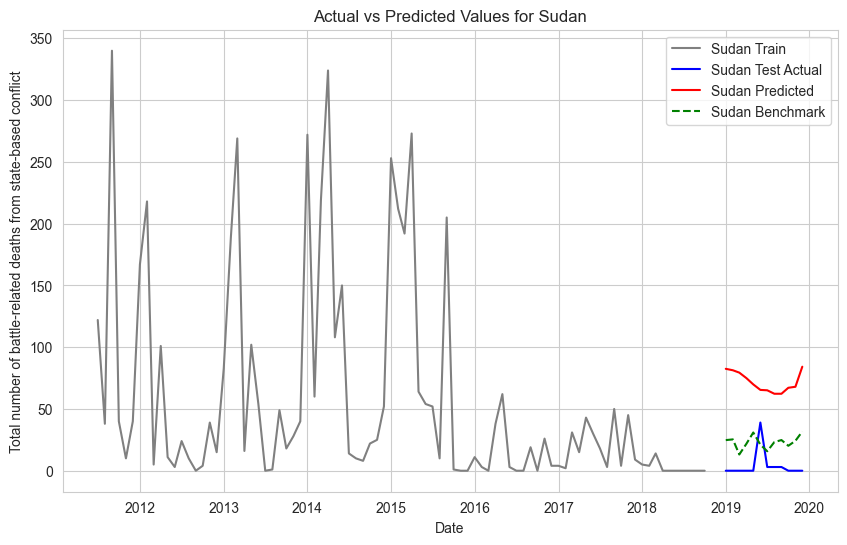

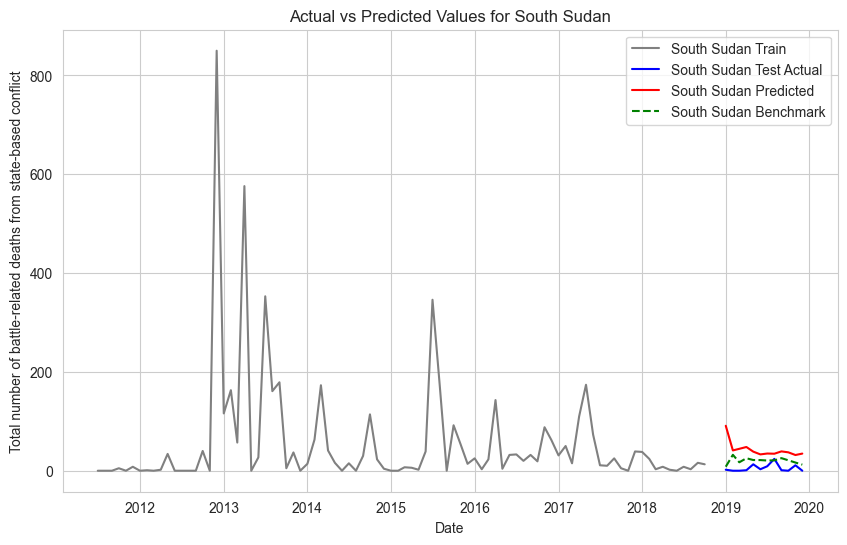

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

country_list = pd.read_csv('data/country_list.csv')

country_ids = test_df['country_id'].unique().tolist()
# drop country if all actuals are 0
# [country_ids.remove(country_id) for country_id in country_ids if test_df[test_df['country_id'] == country_id][target].sum() == 0]

for country_id in country_ids:
    # Data for this country
    this_country_test = test_df[test_df['country_id'] == country_id]
    this_country_train = train_df[train_df['country_id'] == country_id]
    country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

    # skip country if all actuals are 0
    if this_country_test[target].sum() == 0:
        print(f"Skipping {country_name} as all actuals are 0")
        continue

    # # Creating subplot for interactive plot
    # fig = make_subplots(specs=[[{"secondary_y": True}]])
    # 
    # # Add traces
    # fig.add_trace(
    #     go.Scatter(x=this_country_train['date'], y=this_country_train[target], name=f'{country_name} Train', mode='lines', line=dict(color='gray')),
    #     secondary_y=False,
    # )
    # fig.add_trace(
    #     go.Scatter(x=this_country_test['date'], y=this_country_test[target], name=f'{country_name} Test Actual', mode='lines', line=dict(color='blue')),
    #     secondary_y=False,
    # )
    # fig.add_trace(
    #     go.Scatter(x=this_country_test['date'], y=this_country_test['predictions'], name=f'{country_name} Predicted', mode='lines', line=dict(color='red')),
    #     secondary_y=False,
    # )
    # 
    # # Add figure title and adjust layout
    # fig.update_layout(title_text=f"Actual vs Predicted Values for {country_name}")
    # 
    # # Set x-axis title
    # fig.update_xaxes(title_text="Date")
    # 
    # # Set y-axes titles
    # fig.update_yaxes(title_text="GED_SB Value", secondary_y=False)

    # Show plot
    # fig.show()
    # Creating plot
    plt.figure(figsize=(10, 6))

    # Plot training data
    plt.plot(this_country_train['date'], this_country_train[target], label=f'{country_name} Train', color='gray',
             linestyle='-', marker='')

    # Plot test actual data
    plt.plot(this_country_test['date'], this_country_test[target], label=f'{country_name} Test Actual', color='blue',
             linestyle='-', marker='')

    # Plot predicted data
    plt.plot(this_country_test['date'], this_country_test['predictions'], label=f'{country_name} Predicted',
             color='red', linestyle='-', marker='')

    # plot benchmark
    benchmark_country = benchmark_model[benchmark_model['country_id'] == country_id]
    plt.plot(benchmark_country['date'], benchmark_country['outcome'], label=f'{country_name} Benchmark', color='green',
             linestyle='--', marker='')

    # Adding title and labels
    plt.title(f"Actual vs Predicted Values for {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Total number of battle-related deaths from state-based conflict")
    plt.legend()

    # Show plot
    plt.show()

In [23]:
import plotly.graph_objects as go

PLOT_ONE_FIGURE = False
if PLOT_ONE_FIGURE:
    # Assuming country_list, test_df, and train_df are already loaded
    # Creating one figure for all countries
    fig = go.Figure()

    country_ids = test_df['country_id'].unique().tolist()

    for country_id in country_ids:
        # Data for this country
        this_country_test = test_df[test_df['country_id'] == country_id]
        this_country_train = train_df[train_df['country_id'] == country_id]
        country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

        # Add traces for Train Actual
        fig.add_trace(
            go.Scatter(x=this_country_train['date'], y=this_country_train[target], name=f'{country_name} Train',
                       mode='lines', line=dict(color='gray', width=1))
        )

        # Add traces for Test Actual
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test[target], name=f'{country_name} Test Actual',
                       mode='lines', line=dict(color='blue', width=1))
        )

        # Add traces for Predicted
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test['predictions'],
                       name=f'{country_name} Predicted', mode='lines', line=dict(color='red', dash='dot', width=1))
        )

    # Add figure title and adjust layout
    fig.update_layout(
        title_text="Actual vs Predicted Values Across Countries",
        xaxis_title="Date",
        yaxis_title="GED_SB Value",
        legend_title="Legend",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # Show plot
    fig.show()